# Setting up environment modules and basic settings

## Documentation

## Generating the environment (if you use sahre enviroment, its not necessary)

The following needs to be run in the command-line

## Loading modules and settings

In [153]:
import warnings
warnings.filterwarnings("ignore")

In [154]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix + "/lib/R"

In [155]:
from rpy2.robjects import r
print(r('R.version.string'))

[1] "R version 4.0.5 (2021-03-31)"



In [156]:
import scFates as scf
print(scf.__version__)

1.0.6


In [157]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn

In [158]:
import palantir

In [159]:
seaborn.reset_orig()
%matplotlib inline
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

sc.set_figure_params()
scf.set_figure_pubready()
plt.rcParams['font.family'] = 'DejaVu Sans'

# Preprocessing pipeline from Palantir

## Load, normalize and log-transform count data

### Load the data

In [223]:
original_adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust.h5ad')
#original_adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg.h5ad')
#original_adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_pub.h5ad')
#/storage/users/data/PANC/adata_clustered_10066.h5ad'

In [224]:
original_adata.var_names

Index(['ENSG00000188290', 'ENSG00000187608', 'ENSG00000224969',
       'ENSG00000184163', 'ENSG00000142609', 'ENSG00000287586',
       'ENSG00000049246', 'ENSG00000238290', 'ENSG00000180758',
       'ENSG00000117122',
       ...
       'ENSG00000284377', 'ENSG00000235703', 'ENSG00000013619',
       'ENSG00000029993', 'ENSG00000011677', 'ENSG00000198883',
       'ENSG00000182492', 'ENSG00000067842', 'ENSG00000099721',
       'ENSG00000198899'],
      dtype='object', name='feature_id', length=1992)

In [225]:
original_adata

AnnData object with n_obs × n_vars = 6281 × 1992
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [226]:
adata = original_adata

### Test whether there are data errors or gaps or redundancies

In [227]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [228]:
import numpy as np
from scipy.sparse import issparse

# Check if the matrix is sparse
if issparse(adata.X):
    zero_count = adata.X.size - adata.X.nnz
else:
    zero_count = np.count_nonzero(adata.X == 0)

total_elements = adata.X.shape[0] * adata.X.shape[1]
print(f"Total number of zeros: {zero_count}")
print(f"Percentage of zeros: {zero_count / total_elements * 100:.2f}%")

# Check for entirely zero rows or columns
if issparse(adata.X):
    zero_rows = np.squeeze(np.array((adata.X.sum(axis=1) == 0)))
    zero_cols = np.squeeze(np.array((adata.X.sum(axis=0) == 0)))
else:
    zero_rows = np.all(adata.X == 0, axis=1)
    zero_cols = np.all(adata.X == 0, axis=0)

print("Number of completely zero rows: ", np.sum(zero_rows))
print("Number of completely zero columns: ", np.sum(zero_cols))

# Optionally, filter out zero rows and columns
if np.sum(zero_rows) > 0:
    adata = adata[~zero_rows, :]
if np.sum(zero_cols) > 0:
    adata = adata[:, ~zero_cols]

Total number of zeros: 0
Percentage of zeros: 0.00%
Number of completely zero rows:  0
Number of completely zero columns:  0


In [229]:
# Remove zero columns from the dataset
if issparse(adata.X):
    # For sparse matrix
    adata = adata[:, ~np.squeeze(np.array((adata.X.sum(axis=0) == 0)))]
else:
    # For dense matrix
    adata = adata[:, ~np.all(adata.X == 0, axis=0)]

In [230]:
# Count empty strings in var_names
empty_count = np.sum(adata.var_names == "")
print(f"Number of empty strings in var_names: {empty_count}")



Number of empty strings in var_names: 0


In [231]:
# Filter out rows with empty strings in var_names
adata = adata[:, adata.var_names != ""]

In [232]:
adata

View of AnnData object with n_obs × n_vars = 6281 × 1992
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [233]:
print(adata.X.shape)

(6281, 1992)


In [234]:
adata

View of AnnData object with n_obs × n_vars = 6281 × 1992
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [235]:
# Check if all cell names (obs_names) are unique
cell_names_are_unique = (len(adata.obs_names) == len(set(adata.obs_names)))
print("Are cell names unique?", cell_names_are_unique)

# Check if all gene names (var_names) are unique
gene_names_are_unique = (len(adata.var_names) == len(set(adata.var_names)))
print("Are gene names unique?", gene_names_are_unique)

Are cell names unique? True
Are gene names unique? True


## Preprocess data again (optional)

In [173]:
sc.pp.highly_variable_genes(adata, n_top_genes=1900, flavor='cell_ranger')
#sc.pp.scale(adata, max_value=10)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [174]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
#sc.tl.leiden(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


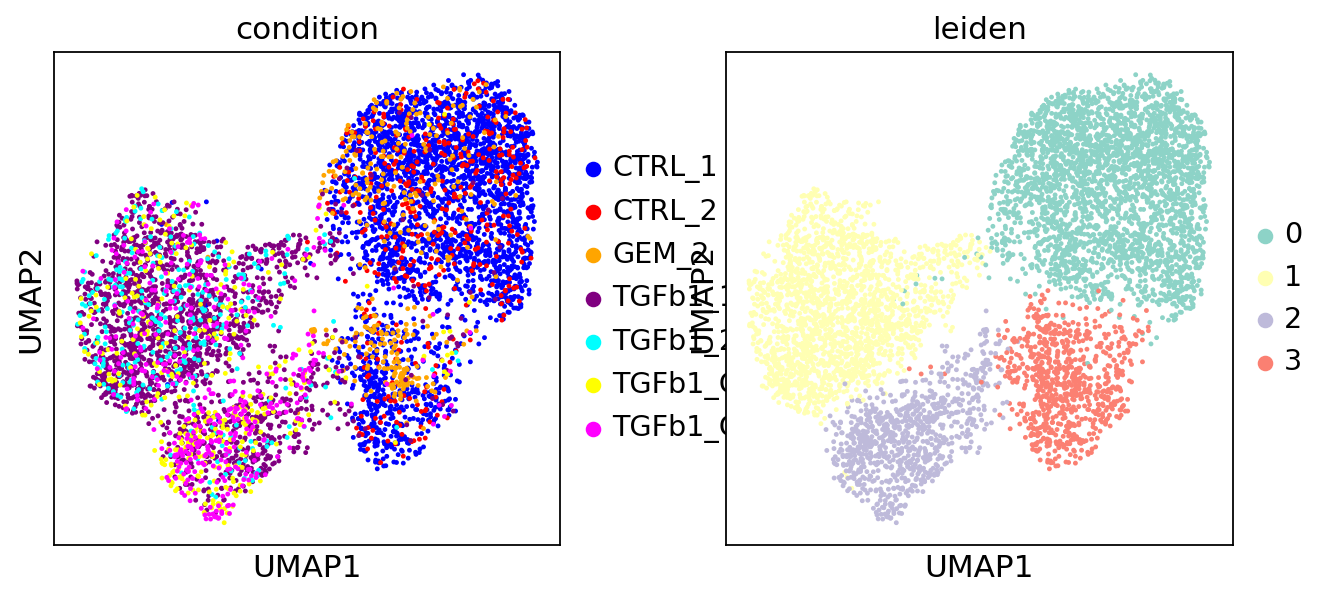

In [175]:
sc.pl.umap(adata, color=[ "condition","leiden"])

## Select PCA projections

In [236]:
# Dimension reduction and Clustering 
sc.tl.pca(adata, svd_solver='arpack')
#sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40) # Neighborhood Graph Construction
#sc.tl.umap(adata) # Compute UMAP embedding

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [237]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [238]:
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

In [239]:
pca_projections

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTAGGCTCC-1,-6.111367,0.340144,-2.912947,0.173341,0.155147,-1.278499,0.140265,0.372492,0.803717,-0.009468,...,-0.791149,0.286663,0.551625,0.291889,-0.512326,-0.293962,-0.133760,-0.757332,0.242030,-0.231450
AAACCCAGTCGCAACC-1,-4.984113,2.366789,0.175433,4.573883,0.870690,2.836679,-0.927790,1.184331,0.284470,0.219863,...,-0.374306,0.699749,-0.015294,-1.136801,0.092315,0.385130,0.107592,0.625948,-0.458320,1.154915
AAACCCATCCACAAGT-1,-3.005431,2.855705,1.004089,-5.442858,1.610621,-3.055193,0.336858,0.547009,1.179886,0.507925,...,0.088807,-1.441126,-0.591027,0.118153,0.686741,0.321253,-0.961179,-0.000102,0.595551,0.246290
AAACGCTTCACTACGA-1,-4.037817,2.974184,-0.193413,-1.496026,-1.554551,-1.198371,1.671796,0.487069,-0.865815,-0.246231,...,0.034537,0.260950,0.154567,-0.701168,-0.841614,0.479461,-0.618895,-1.655810,-0.500538,-0.353596
AAAGAACAGATACAGT-1,-5.233677,2.932000,-0.948813,3.440983,-1.362631,0.648486,1.499442,0.209867,-0.731616,-1.253290,...,-0.772347,0.413526,0.610128,-0.516779,0.075469,-0.750710,-0.286438,-0.479287,0.322809,-0.400776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCATTACTC-1,-1.339151,-1.243520,0.817867,3.254112,2.345587,0.471490,-2.578219,-2.044888,-1.684863,-0.765398,...,-0.739027,-0.041203,0.228458,-0.862982,0.070404,-0.220360,0.202108,-0.446496,0.852636,-0.236384
TTTCACAGTGATATAG-1,6.102983,-4.665879,2.387946,-1.409779,0.591474,-1.444067,0.497795,2.652697,-1.842461,-1.689682,...,-0.225572,0.376387,-0.262378,0.205813,-0.484041,-0.177509,-0.106215,0.051398,-0.194260,-0.220386
TTTCACATCGATGCAT-1,4.467232,-0.863458,3.250190,1.184358,1.211938,1.704528,2.585280,-0.060965,0.092681,-0.676969,...,-0.475593,1.254823,-0.267545,-0.276867,1.142520,0.456610,0.602121,-0.584903,0.535395,-0.644315


## Run Palantir to obtain multiscale diffusion space

In [240]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## Generate embedding from the multiscale diffusion space

In [241]:
# generate neighbor graph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=20,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [242]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, X_palantir

In [243]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:35)


In [244]:
print(adata.obs.keys())
print(adata.var.keys())

Index(['condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mito',
       'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores',
       'predicted_doublets', 'outlier', 'leiden'],
      dtype='object')
Index(['CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells',
       'highly_variable', 'means', 'dispersions', 'dispersions_norm'],
      dtype='object')


## Plotting results

In [245]:
plt.rcParams['figure.figsize'] = [8, 8] 

In [246]:
plt.rcParams['font.family'] = 'DejaVu Sans'

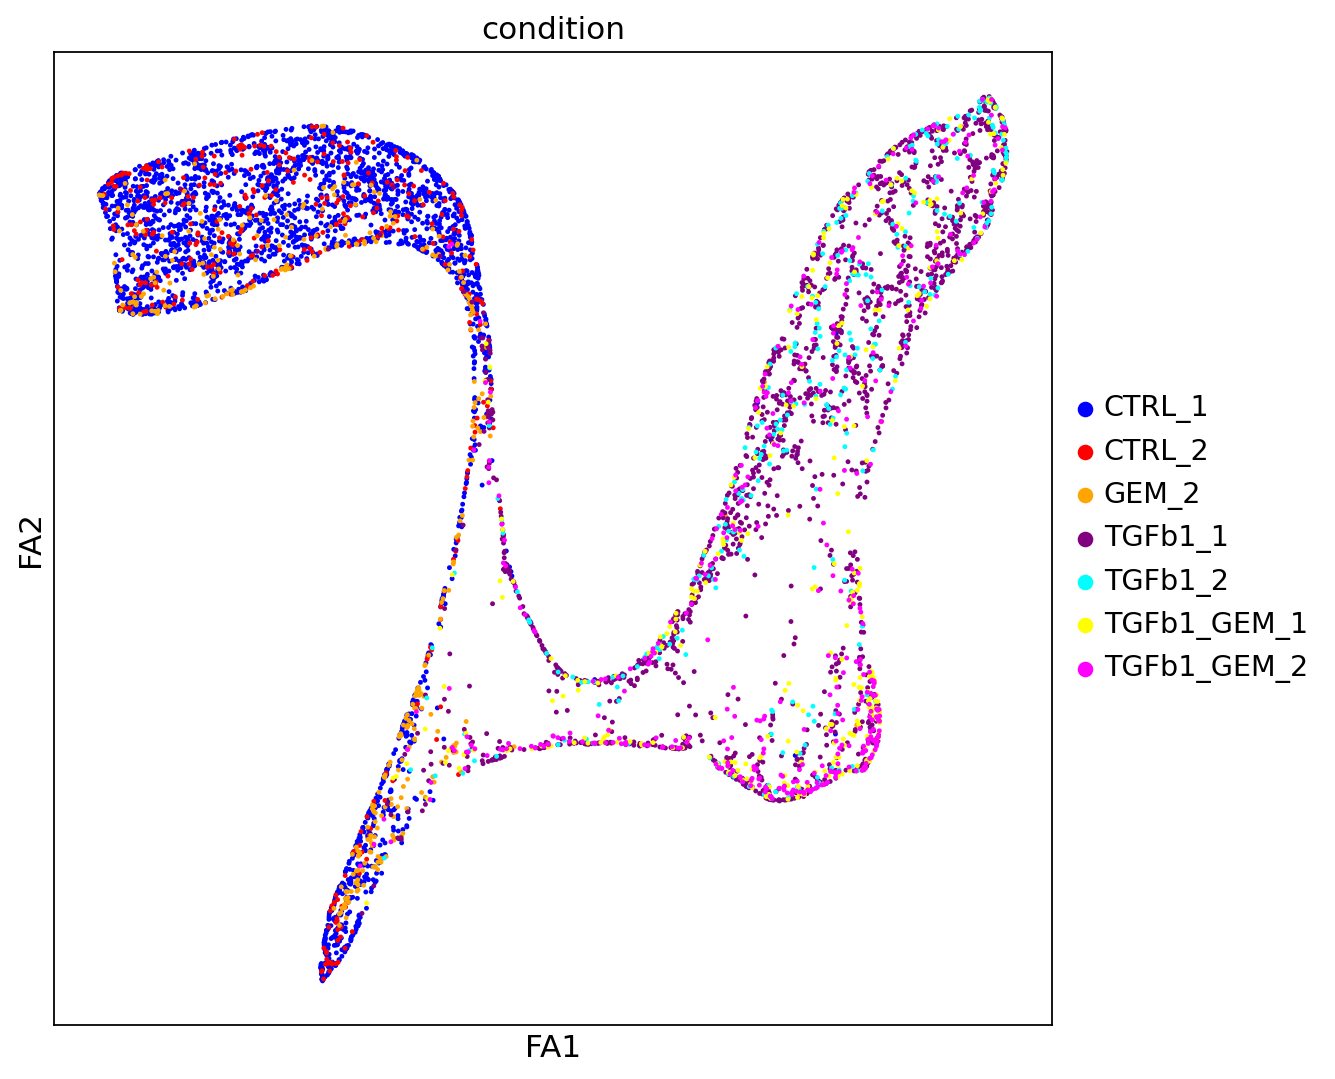

In [247]:
sc.pl.draw_graph(adata,color="condition",color_map="RdBu_r")

In [248]:
adata

AnnData object with n_obs × n_vars = 6281 × 1992
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

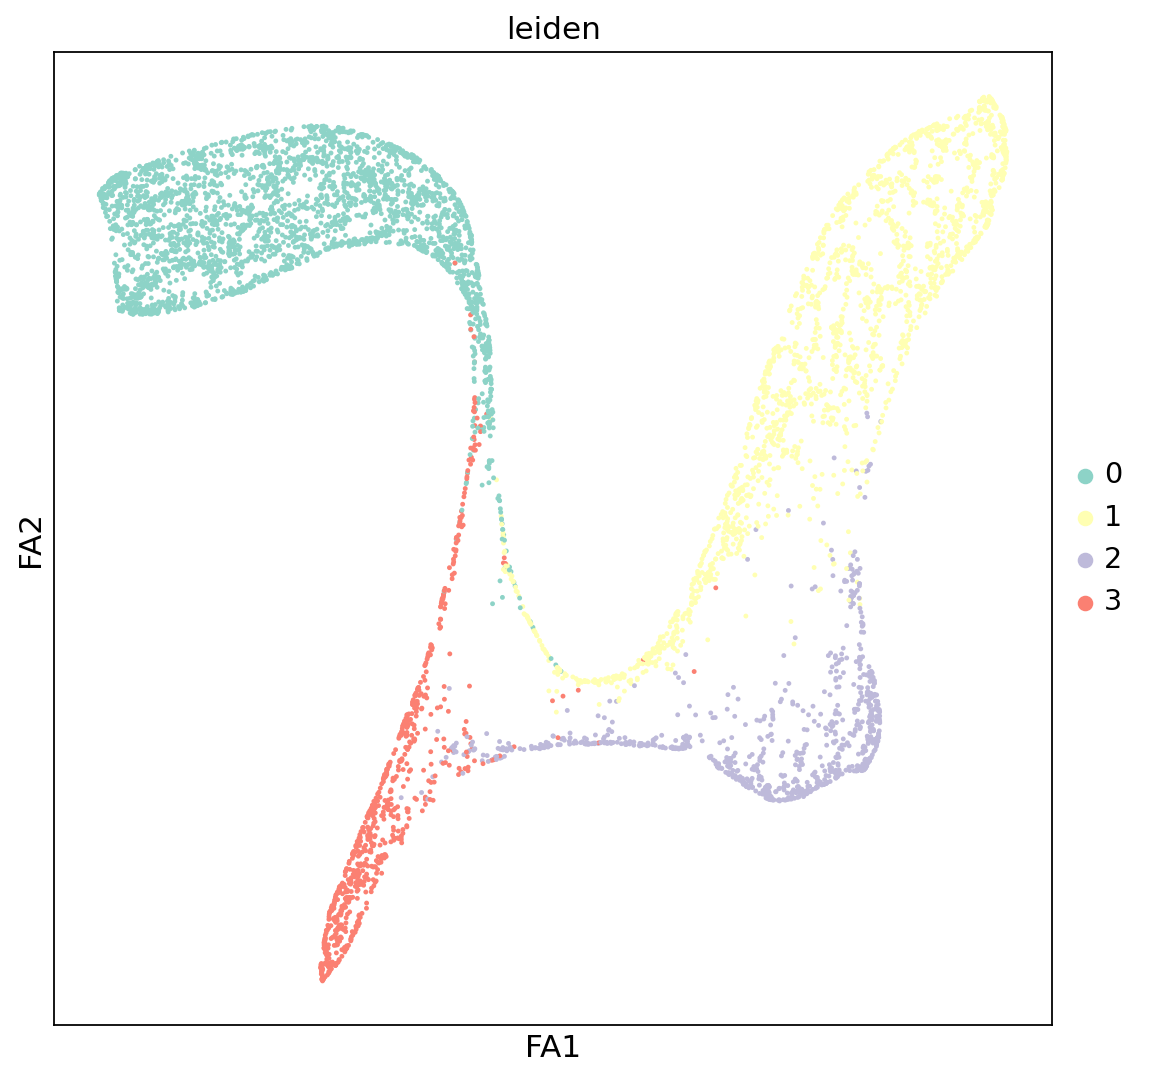

In [249]:
sc.pl.draw_graph(adata,color="leiden",color_map="RdBu_r")

In [250]:
adata.write('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_palantir.h5ad')

In [251]:
adata.write('/scratch/users/data/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_palantir.h5ad')

In [ ]:
adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_palantir.h5ad')